# Simple multilabel classifier
We want to predict the movie genre from the title

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import string
import nltk
import matplotlib.pyplot as plt

## Case study

In [3]:
import pymongo

In [4]:
db_name = 'movie-dialogs'
collection = 'movies'
M = pymongo.MongoClient()[db_name][collection]

In [5]:
training_set, V, K = [], set(), set()

In [6]:
for movie in M.find({}):
    words, classes = movie['title'].split(), movie['genres']
    for w in words:
        V.add(w)
    for k in classes:
        K.add(k)
        training_set.append((words, k))
V = list(V) + ['UNKNOWN']
K = list(K)

In [7]:
training_set[:4]

[(['10', 'things', 'i', 'hate', 'about', 'you'], 'comedy'),
 (['10', 'things', 'i', 'hate', 'about', 'you'], 'romance'),
 (['1492:', 'conquest', 'of', 'paradise'], 'adventure'),
 (['1492:', 'conquest', 'of', 'paradise'], 'biography')]

In [8]:
word2idx = dict([(w, i) for i, w in enumerate(V)])
class2idx = dict([(k, i) for i, k in enumerate(K)])

In [9]:
def encode_title(tokens, word2idx, pad=5):
    encoded = np.zeros(pad, dtype=int)
    enc1 = np.array([word2idx.get(word, word2idx["UNKNOWN"]) for word in tokens])
    length = min(pad, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [10]:
encode_title('this is a title'.split(), word2idx, pad=5)

(array([987, 960, 291, 987,   0]), 4)

## Classifier

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [12]:
class LSTM(nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, target_dim)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.softmax(self.linear(ht[-1]))

In [13]:
losses = []
loss_function = nn.NLLLoss()
model = LSTM(len(V), 100, 32, len(K))
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [15]:
epochs = tqdm(list(range(10)))
for epoch in epochs:
    total_loss = 0
    for title, target in training_set:
        title_idx, l = encode_title(title, word2idx)
        t = torch.tensor(title_idx, dtype=torch.long)
        model.zero_grad()
        log_probs = model(t.view(1, -1), l)
        loss = loss_function(log_probs, torch.tensor([class2idx[target]]))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)

In [16]:
import matplotlib.pyplot as plt

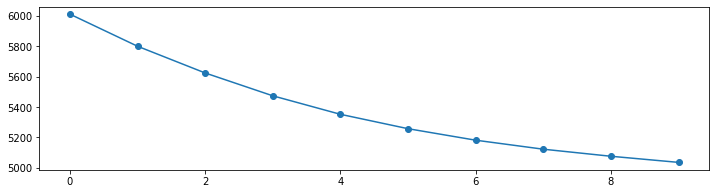

In [17]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(losses, marker='o')
plt.show()

In [24]:
e, l = encode_title('the good the bad and the ugly'.split(), word2idx)
prediction = model(torch.tensor(e).view(1, -1), l)

In [25]:
e

array([506, 387, 506, 382, 589])

In [26]:
probs = np.exp(prediction.detach().numpy())[0]
for i, p in sorted(enumerate(probs), key=lambda x: -x[1]):
    print(K[i], round(p, 2))

drama 0.16
thriller 0.11
crime 0.08
comedy 0.07
action 0.07
adventure 0.06
sci-fi 0.05
romance 0.05
fantasy 0.04
mystery 0.04
horror 0.04
war 0.02
family 0.02
history 0.02
animation 0.02
biography 0.02
western 0.02
film-noir 0.01
 0.01
short 0.01
sport 0.01
documentary 0.01
musical 0.01
music 0.01
adult 0.01


## Exercise
Try to improve the performances by:
- exploiting pre-trained word embedding schemes
- deal with unbalanced classes